# Preselección de Variables

In [1]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(magrittr)
library(zoo)
library(purrr)
library(scales)
library(xgboost)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘purrr’

The following object is masked from ‘package:magrittr’:

    set_names


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard



Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘purrr’

The following object is masked from ‘package:magrittr’:

    set_names


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard




Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice



In [2]:
lista_df_preseleccion_var = readRDS('../02_Variables/lista_df_preseleccion_var.rds')

In [3]:
lista_vectores = list()
lista_df_post_seleccion = list()

In [4]:
params = list(
  objective = "reg:squarederror",
  eval_metric = "rmse",
  lambda = 2,          
  alpha = 2,           
  max_depth = 4,       
  min_child_weight = 5, 
  eta = 0.01,
  subsample = 0.7,     
  colsample_bytree = 0.7, 
  gamma = 1          
)

In [5]:
for (dataframe in names(lista_df_preseleccion_var)){

  nombre_dataframe = dataframe

  df_bucle = lista_df_preseleccion_var[[nombre_dataframe]]

  x = df_bucle %>% select(-date, -store_id, -item_id, -ventas)
  y = df_bucle %>% select(ventas)

  x = as.matrix(x)
  y = as.numeric(y[[1]])

  dtrain = xgb.DMatrix(data = x, label = y)

  xgb_model = xgb.train(
    params = params,
    data = dtrain,
    nrounds = 100,
    verbose = 0 )
  
  importance_matrix = xgb.importance(feature_names = colnames(x), model = xgb_model)

  importance_df = as.data.frame(importance_matrix)
  
  importance_df = importance_df[order(importance_df$Gain, decreasing = TRUE), ]

  variables_seleccionadas = importance_df$Feature

  df_var_selec = df_bucle %>% select(all_of(variables_seleccionadas), ventas, date)

  lista_vectores[[nombre_dataframe]] = variables_seleccionadas
  lista_df_post_seleccion[[nombre_dataframe]] = df_var_selec

}

In [6]:
conteo_variables = lista_vectores %>% unlist() %>% table()
conteo_variables = sort(conteo_variables, decreasing = TRUE)

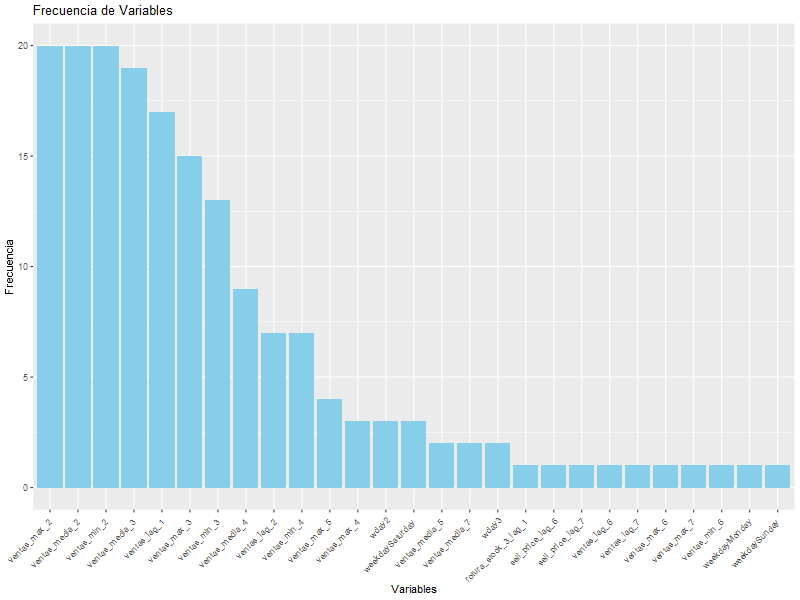

In [7]:
# Convertir conteo_variables a un data.frame
df_conteo = as.data.frame(conteo_variables)

# Renombrar columnas para facilitar el gráfico
colnames(df_conteo) = c("Variable", "Frecuencia")

# Crear el gráfico de barras
ggplot(df_conteo, aes(x = reorder(Variable, -Frecuencia), y = Frecuencia)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  labs(title = "Frecuencia de Variables", x = "Variables", y = "Frecuencia") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Guardamos el resultado.

In [8]:
saveRDS(lista_df_post_seleccion, file = "../02_Variables/lista_df_ps.rds")